In [1]:
import yfinance as yf
from datetime import timedelta, date
import pandas as pd
import numpy as np
import torch
import torchsde
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
STOCK_NAME = "NESN.SW"

START = date.today() - timedelta(days=1)
END = date.today()
TIME_INTERVAL = "1m"
DT = 60

LOCAL_WINDOW_SIZE = 15

DRIFT_LIMIT = 1e-8

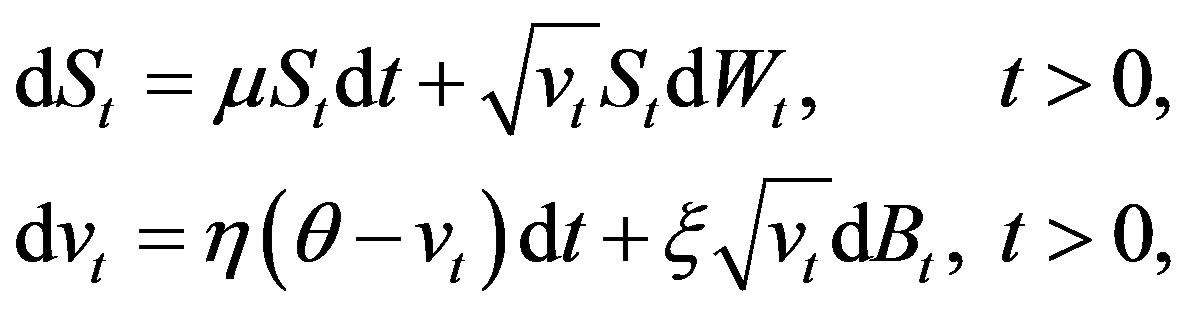

In [3]:
# S
observed_prices = yf.download(STOCK_NAME, start=START, end=END, interval=TIME_INTERVAL)["Adj Close"]
# t
observation_times = observed_prices.index.astype("int64")  # datetime to number of 1e-9 seconds since 1/1/1970
observation_times = (observation_times - min(observation_times)) / 1e9

[*********************100%***********************]  1 of 1 completed


In [4]:
# ν
time_deltas = pd.Series(observation_times.diff(), index=observed_prices.index)
price_quotients = observed_prices.diff() / observed_prices
local_volatilities = price_quotients.rolling(LOCAL_WINDOW_SIZE).var().div(time_deltas).shift(periods=LOCAL_WINDOW_SIZE)

In [5]:
# the observed process as a whole
observed_heston_process = pd.DataFrame({
    "S": observed_prices,
    "t": observation_times,
    "ν": local_volatilities,
    }, index=observed_prices.index
).dropna()

/var/folders/vh/mv3ytp3x2_jg2tcq53sq9f240000gn/T/ipykernel_7582/2652417888.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  _times = torch.tensor(observed_heston_process["t"], requires_grad=False)


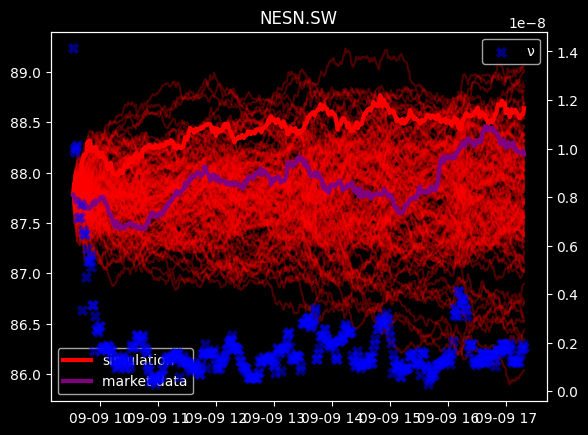

In [6]:
# verification

class SimpleHeston(torch.nn.Module):
    """Neural Heston where local volatility is given."""

    noise_type = "diagonal"
    sde_type = "ito"
    state_size = 1

    def __init__(self, local_volatilities, index):
        super().__init__()
        self.local_volatilities = local_volatilities
        self.index = index

    def f(self, t, y):
        return 0 * y

    def g(self, t, y):
        closest_index = torch.argmin(torch.abs(self.index - t))
        volatility = self.local_volatilities[closest_index]
        return torch.sqrt(volatility) * y

_times = torch.tensor(observed_heston_process["t"], requires_grad=False)
_s0 = torch.tensor(observed_heston_process["S"].iloc[0], requires_grad=False).repeat(128, 1)
_local_volatilities = torch.tensor(list(observed_heston_process["ν"]), requires_grad=False)
_sde = SimpleHeston(_local_volatilities, _times)

_solution = torchsde.sdeint(_sde, _s0, _times, method="euler", dt=DT)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for trajectory in _solution.transpose(0, 1).squeeze():
    ax1.plot(observed_heston_process.index, trajectory, c="red", alpha=.3)
ax1.plot(observed_heston_process.index, _solution.transpose(0, 1).squeeze()[0], c="red", linewidth=3, label="simulation")
ax1.plot(observed_heston_process.index, list(observed_heston_process["S"]), c="purple", linewidth=3, label="market data")
ax1.legend()
ax2.scatter(observed_heston_process.index, list(observed_heston_process["ν"]), c="blue", linewidth=3, alpha=.5, label="ν", marker="x")
ax2.legend()
plt.title(STOCK_NAME)
plt.show()

In [7]:
theta = local_volatilities.mean()
local_volatility_deltas = local_volatilities.diff()
eta = (local_volatility_deltas / (theta - local_volatilities) / time_deltas).mean()
xi = (local_volatility_deltas / np.sqrt(local_volatilities * time_deltas)).std()

In [8]:
class Heston(torch.nn.Module):

    noise_type = "diagonal"
    sde_type = "ito"
    state_size = 2

    def __init__(self, theta, eta, xi, r=.0, q=.0, rho=.0):
        super().__init__()
        self.r = torch.nn.Parameter(torch.tensor(r), requires_grad=False)
        self.q = torch.nn.Parameter(torch.tensor(q), requires_grad=False)
        self.eta = torch.nn.Parameter(torch.tensor(eta), requires_grad=False)
        self.theta = torch.nn.Parameter(torch.tensor(theta), requires_grad=False)
        self.xi = torch.nn.Parameter(torch.tensor(xi), requires_grad=False)
        self.rho = torch.nn.Parameter(torch.tensor(rho), requires_grad=False)  # TODO

    def f(self, t, y):
        return torch.zeros_like(y)

    def g(self, t, y):
        diffusion_1 = y[:, 0] * torch.sqrt(y[:, -1])
        diffusion_2 = self.xi * torch.sqrt(y[:, -1])
        diffusion = torch.stack([diffusion_1, diffusion_2], dim=-1)
        return diffusion.view(y.shape[0], self.state_size)

/var/folders/vh/mv3ytp3x2_jg2tcq53sq9f240000gn/T/ipykernel_7582/725145443.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  times = torch.tensor(observed_heston_process["t"], requires_grad=False)
/var/folders/vh/mv3ytp3x2_jg2tcq53sq9f240000gn/T/ipykernel_7582/725145443.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_states = torch.tensor(observed_heston_process[["S", "ν"]].iloc[0], requires_grad=False).repeat(128, 1)
/var/folders/vh/mv3ytp3x2_jg2tcq53sq9f240000gn/T/ipykernel_7582/725145443.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an und

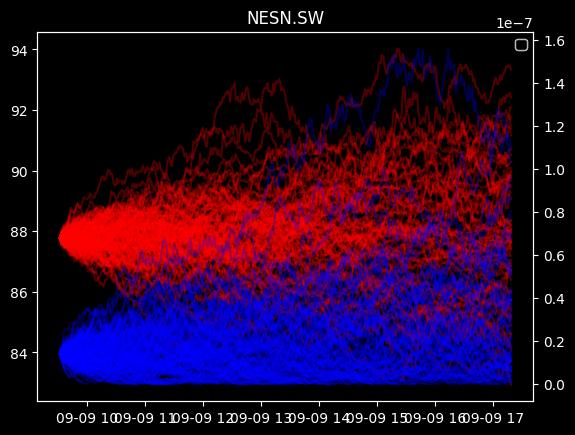

In [9]:
times = torch.tensor(observed_heston_process["t"], requires_grad=False)
initial_states = torch.tensor(observed_heston_process[["S", "ν"]].iloc[0], requires_grad=False).repeat(128, 1)
sde = Heston(theta=theta, eta=eta, xi=xi)

solution = torchsde.sdeint(sde, initial_states, times, method="euler", dt=DT)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for trajectory in solution[..., 0].transpose(0, 1):
    ax1.plot(observed_heston_process.index, trajectory, c="red", alpha=.3)
for trajectory in solution[..., 1].transpose(0, 1):
    ax2.plot(observed_heston_process.index, trajectory, c="blue", alpha=.3)
ax1.legend()
ax2.legend()
plt.title(STOCK_NAME)
plt.show()

